### requires python 3 and TSS conda environment (needed for parallelization)

## Pull out the unique TSS for tissues and run through David

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../parameters/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']

#mRNA_peak_file = doc["mRNA_peak_file"]
#tss_annotation = doc['tss_annotation']


import os
from os.path import join
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
from tqdm import *
from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import helper
import create_output
print('Number of tissues: ',len(tissues))

from collections import Counter


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


Number of tissues:  13


In [2]:
os.chdir(doc["results"])

In [3]:
from numpanpar import parallel_df as pardf

## Parameters and directories

In [4]:
sample_peaks_dir = "tss_annotation_peaks/"
merged_dir = "merged"
#save_dir = "histograms/compare_tissues"


In [5]:
gene_df_f = 'analysis_ncbi_picr/tss_annotation/gene_df_02_tissues.p'

In [6]:
homer_path =  "/data2/resources/software/homer/v4.11_10242019/bin/"
os.environ['PATH'] = f"{homer_path}:{os.environ['PATH']}"
!which homer

/data2/resources/software/homer/v4.11_10242019/bin//homer


## outdir

In [7]:
outdir = "unique_genes"
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [8]:
from collections import defaultdict

In [9]:
def plot_tss_across_tissues_plus_unique(f_in, tissues, landmark_name,
                                f_save=None, tissue_list='Tissues',
                                        is_unique=True):
    df = pickle.load(open(f_in,'rb'), encoding='latin')
    tissues_genes = dict()
    tissues_genes_unique = dict() # The number of unique genes- i.e
                                  # found in only that tissue
        
    tissues_genes_unique_vals = defaultdict(list)
    tissues_genes_vals = defaultdict(list)
    
    for t in tissues:
        tissues_genes[t] = 0
        tissues_genes_unique[t] = 0
    for ind, val in df.iterrows():
        curr_ts = val[tissue_list].split(",")
        if curr_ts[0] == "":
            continue
        for t in curr_ts:
            tissues_genes_vals[t].append(ind)
            tissues_genes[t] += 1
        if len(curr_ts) == 1:
            tissues_genes_unique_vals[curr_ts[0]].append(ind)
            tissues_genes_unique[curr_ts[0]] += 1

    no_peak = []
    for t in tissues_genes:
        if tissues_genes[t] == 0:
            no_peak.append(t)

    for t in no_peak:
        tissues_genes.pop(t, None)

    f,ax = plt.subplots(dpi=300)
    f.patch.set_facecolor("w")
    ax.set_facecolor("w")

    ## Plot
    x = range(len(tissues_genes)+1)
    names = list(tissues_genes.keys()) #Add the total number of genes
    names.append('Cumulative fraction')
    y = 1.0*np.array(list(tissues_genes.values()))/(df.shape[0])
    y = np.append(y, [1.0 * np.sum(df['hasGene']) / (df.shape[0])])
    barlist = plt.bar(x, y, align='center', color="b")


    ## Unique genes
    if is_unique:
        y2 = np.array([1.0*tissues_genes_unique[k] for k in names[
                                                            :-1]])\
                / \
            df.shape[0]
        #y = 1.0 * np.array(tissues_genes_unique.values()) / (
        # df.shape[0])
        y2 = np.append(y2, [1.0 * np.sum(y2)])
        barlist2 = plt.bar(x, y2, align='center',color='g')
        if f_save is not None:
            np.savetxt(f_save + ".vals", np.array((y, y2)),
                       delimiter=",")
    else:
        if f_save is not None:
            np.savetxt(f_save + ".vals", y, delimiter=",")
    ## Plot settings
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    barlist[-1].set_color('purple')
    plt.xticks(range(len(tissues_genes)+1), names, rotation=90)
    plt.ylabel('Fraction of ' + landmark_name + ' covered by tissue',{'fontsize': 22})
    plt.title('TSS across tissues',{'fontsize': 22})
    ax.grid("off")
    ax.yaxis.grid(color="grey")
    if f_save is not None:
        helper_save(f_save)
    
    return tissues_genes_vals,tissues_genes_unique_vals

In [10]:
gene_df = pickle.load(open(gene_df_f,'rb'), encoding='latin')
gene_df

,peaks,closest_to_X_numberOfPeaks,bin_-1000_1000,sameStrand_bin_-1000_1000,samples,minDistance,minDistancePeak,maxValue,maxPeakId,maxSample,Chr,Start,End,Strand,gene,transcript,maxSamples,hasGene,Number of SS,Tissues
Bmp4,"[1394, 3038, 17698, 17726, 21888, 24414, 35067...",129,"[90264, 97971, 124234, 163408, 181215, 308710,...","[90264, 181215, 308710, 348823]","[MiscOrgans_START1_and_MiscOrgans_startinput1,...",27.0,308710,11864.6,308710,NaN,NW_020822366.1,724583,724584,-,Bmp4,XM_027386528.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,4,"Heart,Spleen,MiscOrgans,FemaleReproductive,Bra..."
Cdkn3,"[17679, 17707, 68904, 83014, 89129, 99005, 108...",36,"[138244, 237253]",[237253],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",74.0,237253,15.3,237253,NaN,NW_020822366.1,1085509,1085510,+,Cdkn3,XM_027386531.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1,"BMDMwt,Spleen,MiscOrgans,FemaleReproductive,CH..."
Cnih1,"[14157, 68988, 69200, 116089, 132667, 167473, ...",17,"[132667, 298307, 350581, 353645]",[298307],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",88.0,298307,57.2,298307,NaN,NW_020822366.1,1114325,1114326,-,Cnih1,XM_027386534.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1,"Heart,BMDMwt,Spleen,MiscOrgans,FemaleReproduct..."
Gmfb,"[34817, 35013, 35070, 86845, 97343, 120275, 12...",16,"[35013, 97343, 120275, 122677, 161643, 268973,...",[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
Cgrrf1,"[5407, 35121, 224603, 293332, 306506, 338794, ...",10,"[5407, 293332, 306506, 348288, 414132]",[348288],"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",68.0,348288,144.9,348288,NaN,NW_020822366.1,1159951,1159952,+,Cgrrf1,XM_027386536.1,"[MiscOrgans_START1_and_MiscOrgans_startinput1,...",True,1,"Heart,Spleen,MiscOrgans,FemaleReproductive,CHO..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC113839146,[],0,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
LOC113839147,[],0,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
LOC103158952,[],0,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,
LOC113839149,"[141900, 207964]",2,[],[],[],inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],False,0,


defaultdict(list,
            {'Liver': ['Rnase4',
              'Tppp2',
              'Hgfac',
              'LOC100774582',
              'Npc1l1',
              'LOC113832526',
              'LOC100772459',
              'LOC103158560',
              'LOC100758624',
              'Gdf2',
              'Hacl1',
              'LOC100763710',
              'Fbxo7',
              'Amdhd1',
              'Ccdc38',
              'Ftcd',
              'Dnase2b',
              'Sp7',
              'Angptl7',
              'LOC100770654',
              'Tas1r3',
              'LOC113833877',
              'LOC113830730',
              'Ptcd2',
              'Ttpa',
              'LOC103158544',
              'Cabyr',
              'Atp2a1',
              'Hpx',
              'Dnhd1',
              'LOC100763140',
              'LOC100764807',
              'Cpn1',
              'LOC100751778',
              'LOC100772776',
              'LOC100757012',
              'LOC100755549',
        

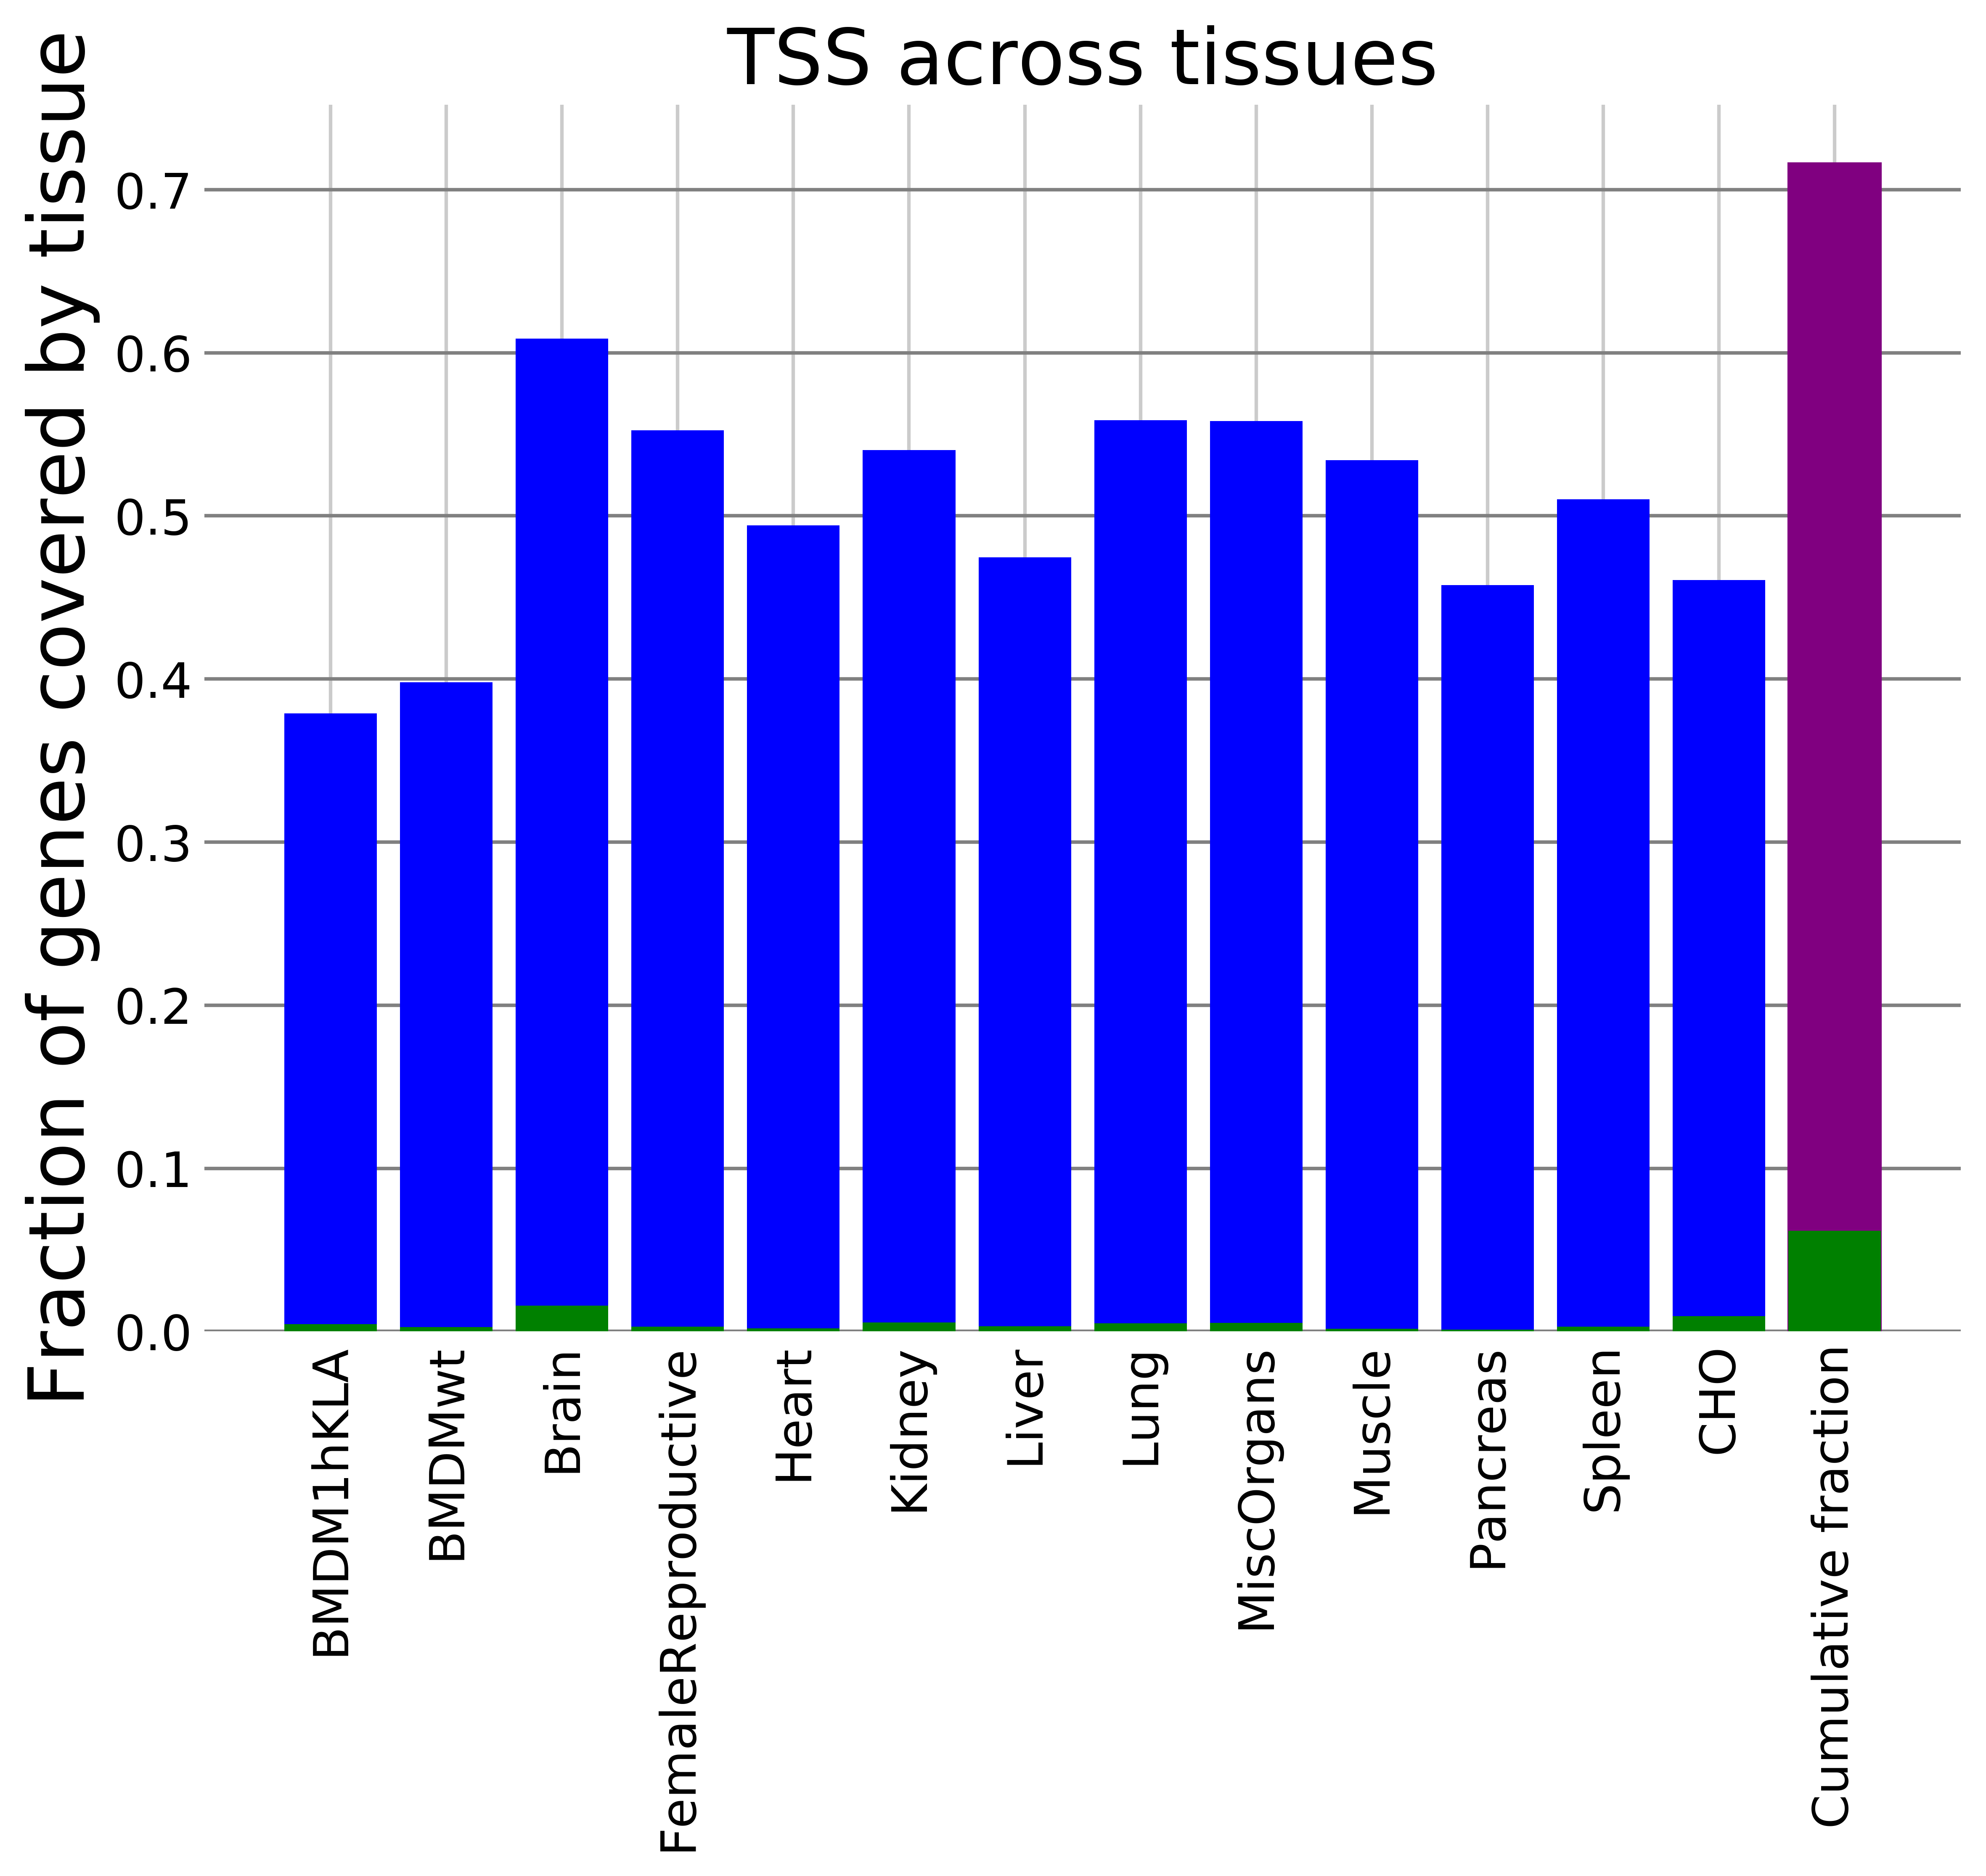

In [11]:
tissues_genes_vals,tissues_genes_unique_vals = plot_tss_across_tissues_plus_unique(gene_df_f, tissues, landmark_name='genes',
                                f_save=None, tissue_list='Tissues',
                                        is_unique=True)
tissues_genes_unique_vals

In [13]:
for t in tissues_genes_unique_vals:
    with open(join(outdir,t+".uniqueGenes.txt"),'w') as f:
        f.write("\n".join(tissues_genes_unique_vals[t]))
    print(t)
    print(len(tissues_genes_unique_vals[t]))

Liver
70
Lung
105
MiscOrgans
112
Brain
340
BMDM1hKLA
94
Kidney
119
CHO
198
FemaleReproductive
63
Muscle
36
Spleen
65
BMDMwt
58
Pancreas
23
Heart
38


In [ ]:
for g in tissues_genes_unique_vals['Brain']:
    print(g)

In [ ]:
for g in tissues_genes_unique_vals['Heart']:
    print(g)